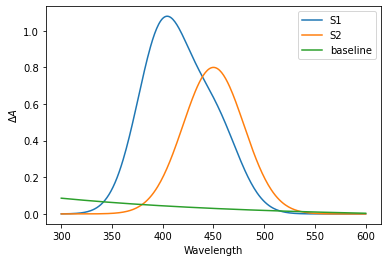

In [91]:
import numpy as np  # import numpy package (abbreviation stands for Numerical Python)
import matplotlib.pyplot as plt  # we plot graphs with this library
import matplotlib
from numba import njit, jit, vectorize, prange
import numba
from typing import Union
from scipy.integrate import odeint
from matplotlib import cm
import matplotlib as mpl
import math
from numpy.linalg import svd
from scipy.integrate import cumtrapz

def plot_matrix(times: np.ndarray, wavelengths: np.ndarray, D: np.ndarray, zlim=(None, None),
               title='', cmap='hot_r'):
    
    zmin, zmax = zlim[0] if zlim[0] is not None else np.nanmin(D), zlim[1] if zlim[1] is not None else np.nanmax(D)
    
    x, y = np.meshgrid(wavelengths, times)  # needed for pcolormesh to correctly scale the image
    
    plt.pcolormesh(x, y, D, cmap=cmap, shading='auto', vmin=zmin, vmax=zmax)
    plt.colorbar(label='$\Delta A$')
    plt.xlabel('Wavelength $\\rightarrow$')
    plt.ylabel('$\\leftarrow$ Time ')
#     plt.gca().invert_yaxis()
#     plt.yscale('symlog', linthresh=1, linscale=1)
    plt.title(title)
#     plt.gca().yaxis.set_major_formatter(ScalarFormatter())
    plt.show()
    
def save_matrix(D, times, wavelengths, fname='output.txt', delimiter='\t', encoding='utf8'):
    # crop the data if necessary
    mat = np.vstack((wavelengths, D))
    buffer = delimiter + delimiter.join(f"{num}" for num in times) + '\n'
    buffer += '\n'.join(delimiter.join(f"{num}" for num in row) for row in mat.T)

    with open(fname, 'w', encoding=encoding) as f:
        f.write(buffer)

    
wavelengths = np.arange(300, 601)
    
def gauss(x: Union[int, float, np.ndarray], mu: Union[int, float, np.ndarray], 
          sigma: Union[int, float, np.ndarray]) -> np.ndarray:
    return np.exp(-(x - mu) * (x - mu) / (2 * sigma * sigma))

S1 = gauss(wavelengths, 400, 25) + 0.5 * gauss(wavelengths, 450, 25)  # ground state bleach
S2 = 0.8 * gauss(wavelengths, 450, 30)  # excited state absorption band 1
Baseline = 0.05*np.exp(-0.005 * (wavelengths - 450)) - 0.02

S = np.vstack((S1, S2)).T
S_baseline = np.hstack((S, Baseline[:, None]))

# plot individual bands

plt.plot(wavelengths, S1, label='S1')
plt.plot(wavelengths, S2, label='S2')
plt.plot(wavelengths, Baseline, label='baseline')

plt.xlabel('Wavelength')
plt.ylabel('$\Delta A$')
plt.legend()
plt.show()

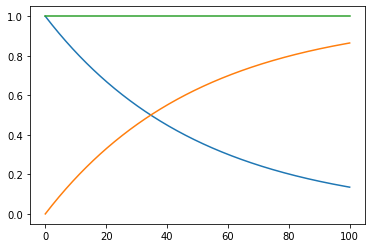

In [85]:
times = np.linspace(0, 100, 400)
k = 0.02
c = np.exp(-k * times)
C = np.vstack((c, 1-c)).T
C_baseline = np.hstack((C, np.ones_like(times)[:, None]))

plt.plot(times, C_baseline)
plt.show()

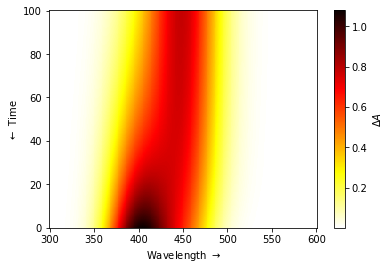

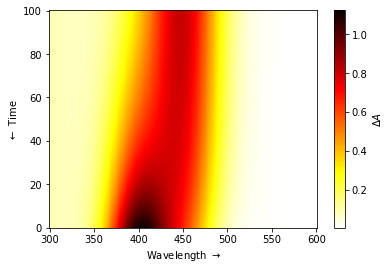

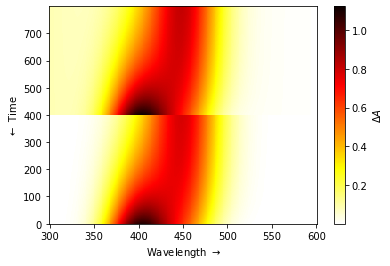

In [92]:
D = C @ S.T
D_baseline = C_baseline @ S_baseline.T

D_mix = np.vstack((D, D_baseline))
t_mix = np.arange(0, D_mix.shape[0], 1)

save_matrix(D, times, wavelengths, fname='D_test.txt')
save_matrix(D_baseline, times, wavelengths, fname='D_baseline_test.txt')

plot_matrix(times, wavelengths, D)
plot_matrix(times, wavelengths, D_baseline)
plot_matrix(t_mix, wavelengths, D_mix)


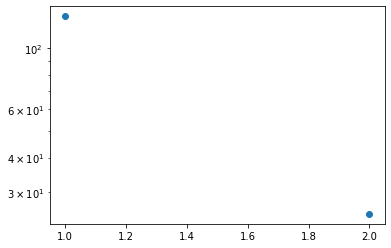

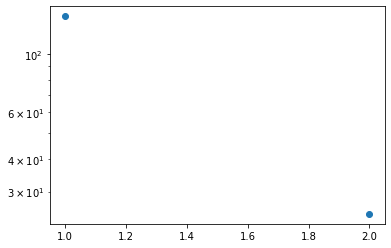

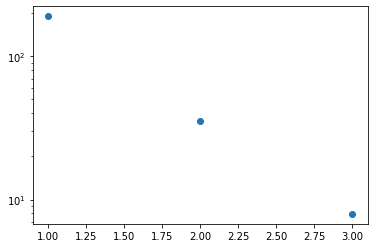

96.60255150497751

In [93]:
def get_svd_vectors(D, rcond=1e-10):
    U, S, VT = svd(D, full_matrices=False)
    cutoff = rcond * S.max()
    large = S > cutoff
    Sr = S[large]
    Ur = U[:, large]
    VrT = VT[large, :]
    
    return Sr, Ur, VrT

def plot_singular_vals(D, rcond=1e-10):
    Sr, Ur, VrT = get_svd_vectors(D, rcond)
    
    plt.scatter(np.arange(1, Sr.shape[0]+1,1), Sr)
    plt.yscale('log')
    plt.show()
    
    return Sr, Ur, VrT

def SVD_power(D, n_vals=2):
    U, S, VT = svd(D, full_matrices=False)
    return 100 * S[:n_vals].sum() / S.sum()
    
Sr, Ur, VrT = plot_singular_vals(D)
Srb, Urb, VrTb = plot_singular_vals(D_baseline)
Srm, Urm, VrTm = plot_singular_vals(D_mix)

SVD_power(D_mix)

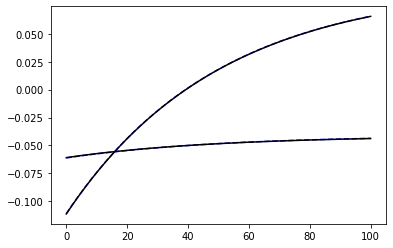

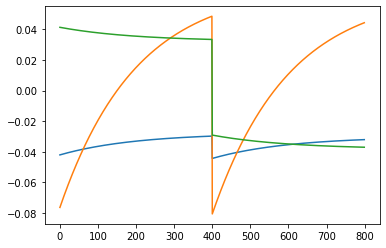

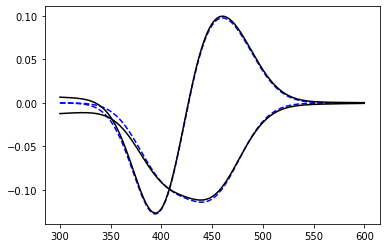

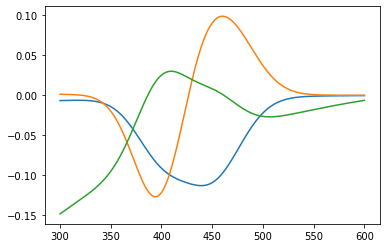

In [90]:
plt.plot(times, Ur, 'b', ls='--')
plt.plot(times, Urb, 'k')

plt.show()
plt.plot(t_mix, Urm)
plt.show()

plt.plot(wavelengths, VrT.T, 'b', ls='--')
plt.plot(wavelengths, VrTb.T, 'k')

plt.show()
plt.plot(wavelengths, VrTm.T)

plt.show()

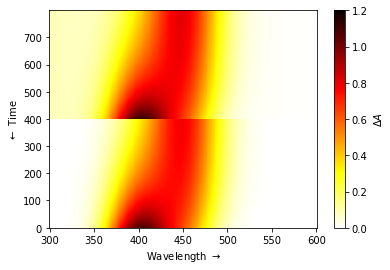

[190.62789984  35.17721405   7.94141803] 197.27889044875673
[190.62855347  35.1772195    7.46993196] 183.27562140098271
[190.629207    35.17722488   6.99834052] 170.1848853404434
[190.62986044  35.1772302    6.52665055] 158.00714204114882
[190.63051378  35.17723548   6.05486883] 146.7428189809027
[190.63116704  35.1772407    5.58300218] 136.39231138138092
[190.63182022  35.17724588   5.11105739] 126.95598224428161
[190.63247333  35.17725102   4.63904123] 118.43416238379874
[190.63312638  35.17725613   4.16696048] 110.82715045563772
[190.63377937  35.1772612    3.6948219 ] 104.13521298276218
[190.63443231  35.17726625   3.22263226] 98.35858437803384
[190.63508521  35.17727127   2.7503983 ] 93.49746696388407
[190.63573806  35.17727627   2.27812679] 89.55203098913479
[190.63639089  35.17728126   1.80582445] 86.52241464306526
[190.63704369  35.17728623   1.33349805] 84.40872406680558
[190.63769648  35.1772912    0.8611543 ] 83.21103336211942
[190.63834926  35.17729616   0.38879996] 82.9293

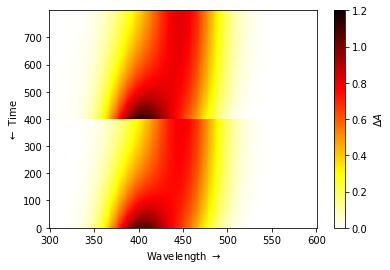

In [148]:
# D is correct, D_baseline is wrong, lets modify D_baseline to minimize the 3rd singular value and remove the baseline

def get_D_mix(D_subtr, D_baseline=D_baseline):
    D_baseline_modif = D_baseline - D_subtr
    return np.vstack((D,D_baseline_modif)), D_baseline_modif

_D_mix, D_baseline_modif = get_D_mix(0)
plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

vectors = []
for i in range(18):
    Sr, Ur, VrT = get_svd_vectors(_D_mix)
#     print(Sr)
    V_subtr = np.outer(Ur[:, -1], VrT[-1])[times.shape[0]:].mean(axis=0)
    vectors.append(V_subtr)
#     plt.plot(wavelengths, V_subtr)
#     plt.show()
    _D_mix, D_baseline_modif = get_D_mix(V_subtr, D_baseline_modif)
    res = D - D_baseline_modif
    ssq = (res ** 2).sum()
    print(Sr, ssq)

plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

vectors = np.asarray(vectors)


    
# plt.plot(wavelengths, VrT.T)
# plt.show()

# _D_mix = get_D_mix(-0.5*VrT[-1])
# plot_matrix(t_mix, wavelengths, _D_mix, zlim=(0, 1.2))

# Sr, Ur, VrT = get_svd_vectors(_D_mix)
# plt.plot(wavelengths, VrT.T)
# plt.show()
# Sr

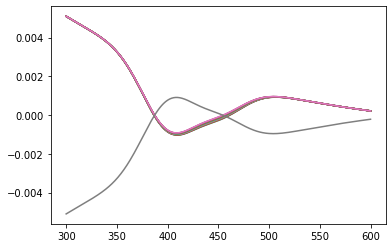

In [142]:
plt.plot(wavelengths, vectors.T)
plt.show()


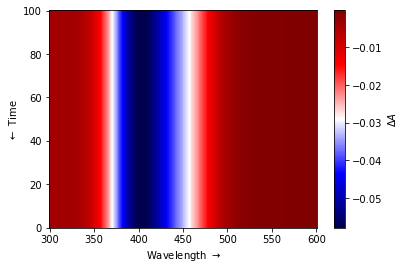

In [147]:
res = D - D_baseline_modif
plot_matrix(times, wavelengths, res, cmap='seismic')
